# Описание

В работе датасет, содержащий информацию об объявлениях на Airbnb в Лондоне.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах; поскольку столбцов очень много, нужные перечислены в текстах самих задач

In [12]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [13]:
connection = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings

In [14]:
query = """
SELECT
    COUNT(*) AS NumRows
FROM default.ldn_listings
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,NumRows
0,85207


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

In [15]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_quan 
FROM default.ldn_listings
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price_quan
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [16]:
df = df.groupby('room_type')

In [17]:
df.price_quan.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price_quan, dtype: float64

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating).

In [18]:
query = """
SELECT
    toFloat32OrNull(review_scores_rating) AS review_scores,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price_quan 
FROM default.ldn_listings
WHERE 
    review_scores != 0 
ORDER BY id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,review_scores,room_type,price_quan
0,97.0,Private room,65.0
1,96.0,Entire home/apt,100.0
2,94.0,Entire home/apt,300.0
3,93.0,Entire home/apt,65.0
4,96.0,Private room,29.0
...,...,...,...
995,100.0,Entire home/apt,165.0
996,93.0,Private room,99.0
997,100.0,Private room,45.0
998,88.0,Private room,20.0


Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [19]:
df_1 = df.groupby('room_type') [['price_quan','review_scores']]\
    .agg('mean').reset_index()

In [20]:
df_1

,room_type,price_quan,review_scores
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


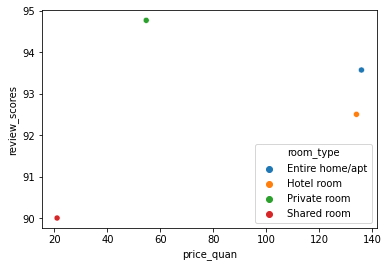

In [21]:
sns.scatterplot(data=df_1, x="price_quan", y="review_scores", hue = 'room_type')

In [22]:
df.price_quan.mean()

94.298

In [23]:
df.review_scores.mean()

94.169

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 

In [24]:
query = """
SELECT
    DISTINCT host_id AS host_id_uniq,
    host_verifications
FROM default.ldn_listings
WHERE 
    experiences_offered != 'none'
"""
df = ph.read_clickhouse(query, connection=connection)
df

,host_id_uniq,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


Cколько раз встречается каждый способ верификации?

In [25]:
df ['host_verifications'] = df.host_verifications.apply(lambda x: x.replace("'", '').replace("[", '').replace("]", '').replace(' ', '').split(','))

In [26]:
df = df.explode('host_verifications')

In [27]:
df.host_verifications.value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

In [28]:
query = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    COUNT (experiences_offered) AS experiences_count
FROM default.ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""
df = ph.read_clickhouse(query, connection=connection)
df

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [29]:
df = df.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')

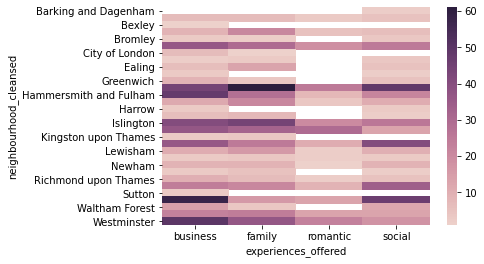

In [30]:
sns.heatmap(df, cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

In [31]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
85202,Private room,100.0
85203,Private room,100.0
85204,Private room,100.0
85205,Private room,100.0


Постройте график распределения цен для каждого типа жилья

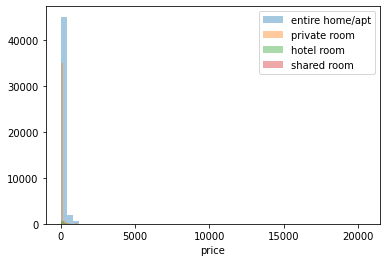

In [39]:
sns.distplot((df.query("room_type=='Entire home/apt'").price), kde=False, label='entire home/apt')
sns.distplot((df.query("room_type=='Private room'").price), kde=False, label='private room')
sns.distplot((df.query("room_type=='Hotel room'").price), kde=False, label='hotel room')
sns.distplot((df.query("room_type=='Shared room'").price), kde=False, label='shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

price – цена за ночь

first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

In [40]:
query = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection)
df

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [41]:
df['first_review'] = df['first_review'].astype(str).str[:-6].replace('', pd.NA).astype(int)

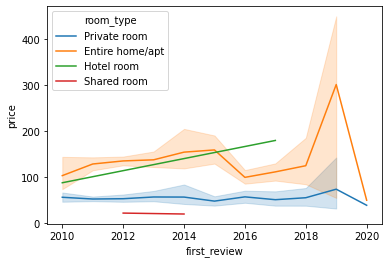

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x='first_review',y='price',hue='room_type',data=df)